# Explain model Dalex

# Instance Level

## 6. Break-down Plots for additive attribution

Probably the most commonly asked question when trying to understand a model’s prediction for a single observation is: which variables contribute to this result the most? There is no single best approach that can be used to answer this question. In this chapter, we introduce break-down (BD) plots, which offer a possible solution. The plots can be used to present “variable attributions”, i.e., the decomposition of the model’s prediction into contributions that can be attributed to different explanatory variables. 

In [44]:
# Preprocess data
import pandas as pd
import numpy as np
# Visual data
import matplotlib.pyplot as plt
import seaborn as sns
# ML
import sklearn as sk
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import compose
from sklearn import metrics
# Explainn model
import dalex as dx

In [45]:
import dalex as dx
titanic = dx.datasets.load_titanic()
X = titanic.drop(columns='survived')
y = titanic.survived

In [46]:
titanic

,gender,age,class,embarked,fare,sibsp,parch,survived
0,male,42.0,3rd,Southampton,7.11,0,0,0
1,male,13.0,3rd,Southampton,20.05,0,2,0
2,male,16.0,3rd,Southampton,20.05,1,1,0
3,female,39.0,3rd,Southampton,20.05,1,1,1
4,female,16.0,3rd,Southampton,7.13,0,0,1
...,...,...,...,...,...,...,...,...
2202,male,41.0,deck crew,Belfast,0.00,0,0,1
2203,male,40.0,victualling crew,Southampton,0.00,0,0,1
2204,male,32.0,engineering crew,Southampton,0.00,0,0,0
2205,male,20.0,restaurant staff,Southampton,0.00,0,0,0


In [47]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

preprocess = make_column_transformer(
    (StandardScaler(), ['age', 'fare', 'parch', 'sibsp']),
    (OneHotEncoder(), ['gender', 'class', 'embarked']))

In [48]:
from sklearn.linear_model import LogisticRegression

titanic_lr = make_pipeline(
    preprocess,
    LogisticRegression(penalty = 'l2'))
titanic_lr.fit(X, y)

from sklearn.ensemble import RandomForestClassifier

titanic_rf = make_pipeline(
    preprocess,
    RandomForestClassifier(max_depth = 3, n_estimators = 500))
titanic_rf.fit(X, y)

#from sklearn.ensemble import GradientBoostingClassifier

#titanic_gbc = make_pipeline(
#    preprocess,
#    GradientBoostingClassifier(n_estimators = 100))
#titanic_gbc.fit(X, y)

#from sklearn.svm import SVC

#titanic_svm = make_pipeline(
#    preprocess,
#    SVC(probability = True))
#titanic_svm.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'fare', 'parch',
                                                   'sibsp']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['gender', 'class',
                                                   'embarked'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=3, n_estimators=500))])

In [49]:
henry = pd.DataFrame({'gender'   : ['male'],
                       'age'     : [47],
                       'class'   : ['1st'],
                       'embarked': ['Cherbourg'],
                       'fare'    : [25],
                       'sibsp'   : [0],
                       'parch'   : [0]},
                      index = ['Henry'])
titanic_lr.predict_proba(henry)
# array([[0.56798421 0.43201579]])
titanic_rf.predict_proba(henry)
# array([[0.69917845 0.30082155]])
titanic_gbc.predict_proba(henry)
# array([[0.78542886 0.21457114]])
titanic_svm.predict(henry)
# array([[0.81725832 0.18274168]])

array([0], dtype=int64)

In [50]:
titanic_rf_exp = dx.Explainer(titanic_rf, X, y, 
                  label = "Titanic RF Pipeline")

Preparation of a new explainer is initiated

  -> data              : 2207 rows 7 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2207 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Titanic RF Pipeline
  -> predict function  : <function yhat_proba_default at 0x000001BAEA6FD040> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.166, mean = 0.322, max = 0.898
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.84, mean = -0.000338, max = 0.83
  -> model_info        : package sklearn

A new explainer has been created!


In [51]:
bd_henry = titanic_rf_exp.predict_parts(henry, 
             type = 'break_down')
bd_henry.result

,variable_name,variable_value,variable,cumulative,contribution,sign,position,label
0,intercept,1,intercept,0.322495,0.322495,1.0,8,Titanic RF Pipeline
1,class,1st,class = 1st,0.392846,0.070351,1.0,7,Titanic RF Pipeline
2,embarked,Cherbourg,embarked = Cherbourg,0.419386,0.026540,1.0,6,Titanic RF Pipeline
3,fare,25.0,fare = 25.0,0.428133,0.008747,1.0,5,Titanic RF Pipeline
4,sibsp,0.0,sibsp = 0.0,0.428261,0.000128,1.0,4,Titanic RF Pipeline
5,parch,0.0,parch = 0.0,0.424771,-0.003490,-1.0,3,Titanic RF Pipeline
6,age,47.0,age = 47.0,0.418326,-0.006445,-1.0,2,Titanic RF Pipeline
7,gender,male,gender = male,0.306842,-0.111484,-1.0,1,Titanic RF Pipeline
8,,,prediction,0.306842,0.306842,1.0,0,Titanic RF Pipeline


In [52]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

#import IPython # Config IPython run in vevery cell
#IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

In [53]:
# Import the necessaries libraries
#import plotly.offline as pyo
# Set notebook mode to work in offline
#pyo.init_notebook_mode()

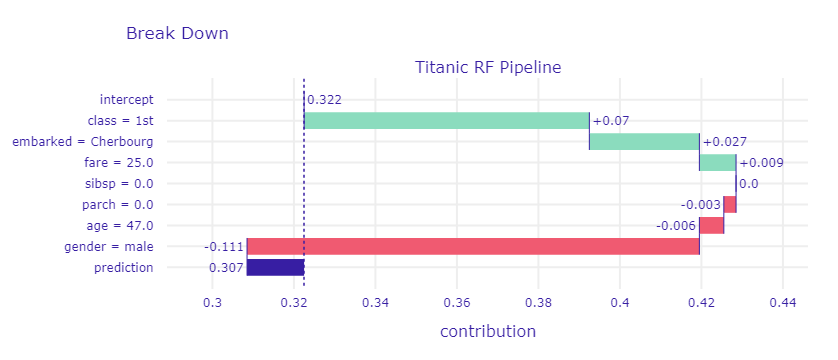

In [54]:
#configure_plotly_browser_state()
bd_henry.plot()

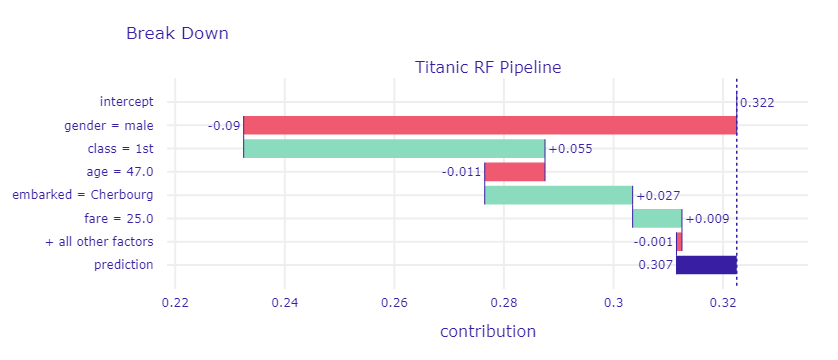

In [55]:
#import numpy as np
#configure_plotly_browser_state()
bd_henry = titanic_rf_exp.predict_parts(henry,
        type = 'break_down',
        order = np.array(['gender', 'class', 'age',
            'embarked', 'fare', 'sibsp', 'parch']))
bd_henry.plot(max_vars = 5)

## 7 Break-down Plots for Interactions

In Chapter 6, we presented a model-agnostic approach to the calculation of the attribution of an explanatory variable to a model’s predictions. However, for some models, like models with interactions, the results of the method introduced in Chapter 6 depend on the ordering of the explanatory variables that are used in computations.

In this chapter, we present an algorithm that addresses the issue. In particular, the algorithm identifies interactions between pairs of variables and takes them into account when constructing break-down (BD) plots. In our presentation, we focus on pairwise interactions that involve pairs of explanatory variables, but the algorithm can be easily extended to interactions involving a larger number of variables.


In [56]:
import pandas as pd
henry = pd.DataFrame({'gender': ['male'], 'age': [47],
           'class': ['1st'],
           'embarked': ['Cherbourg'], 'fare': [25],
           'sibsp': [0], 'parch': [0]},
           index = ['Henry'])
import dalex as dx
titanic_rf_exp = dx.Explainer(titanic_rf, X, y, 
           label = "Titanic RF Pipeline")

Preparation of a new explainer is initiated

  -> data              : 2207 rows 7 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2207 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Titanic RF Pipeline
  -> predict function  : <function yhat_proba_default at 0x000001BAEA6FD040> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.166, mean = 0.322, max = 0.898
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.84, mean = -0.000338, max = 0.83
  -> model_info        : package sklearn

A new explainer has been created!


In [57]:
bd_henry = titanic_rf_exp.predict_parts(henry, 
                type = 'break_down_interactions', 
                interaction_preference = 10)
bd_henry.result

,variable_name,variable_value,variable,cumulative,contribution,sign,position,label
0,intercept,1,intercept,0.322495,0.322495,1.0,5,Titanic RF Pipeline
1,class:gender,1st:male,class:gender = 1st:male,0.287316,-0.035178,-1.0,4,Titanic RF Pipeline
2,fare:embarked,25.0:Cherbourg,fare:embarked = 25.0:Cherbourg,0.322409,0.035093,1.0,3,Titanic RF Pipeline
3,parch:sibsp,0.0:0.0,parch:sibsp = 0.0:0.0,0.316629,-0.005780,-1.0,2,Titanic RF Pipeline
4,age,47.0,age = 47.0,0.306842,-0.009787,-1.0,1,Titanic RF Pipeline
5,,,prediction,0.306842,0.306842,1.0,0,Titanic RF Pipeline


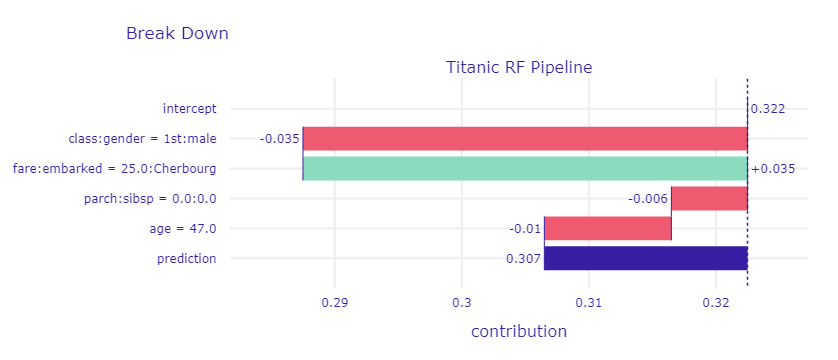

In [58]:
bd_henry.plot()

## 8 Shapley Additive Explanations (SHAP) for Average Attributions

In Chapter 6, we introduced break-down (BD) plots, a procedure for calculation of attribution of an explanatory variable for a model’s prediction. We also indicated that, in the presence of interactions, the computed value of the attribution depends on the order of explanatory covariates that are used in calculations. One solution to the problem, presented in Chapter 6, is to find an ordering in which the most important variables are placed at the beginning. Another solution, described in Chapter 7, is to identify interactions and explicitly present their contributions to the predictions.

In this chapter, we introduce yet another approach to address the ordering issue. It is based on the idea of averaging the value of a variable’s attribution over all (or a large number of) possible orderings. The idea is closely linked to “Shapley values” developed originally for cooperative games (Shapley 1953). The approach was first translated to the machine-learning domain by Štrumbelj and Kononenko (2010) and Štrumbelj and Kononenko (2014). It has been widely adopted after the publication of the paper by Lundberg and Lee (2017) and Python’s library for SHapley Additive exPlanations, SHAP (Lundberg 2019). The authors of SHAP introduced an efficient algorithm for tree-based models (Lundberg, Erion, and Lee 2018). They also showed that Shapley values could be presented as a unification of a collection of different commonly used techniques for model explanations (Lundberg and Lee 2017).

In [59]:
import pandas as pd
henry = pd.DataFrame({'gender'   : ['male'],
                       'age'     : [47],
                       'class'   : ['1st'],
                       'embarked': ['Cherbourg'],
                       'fare'    : [25],
                       'sibsp'   : [0],
                       'parch'   : [0]},
                      index = ['Henry'])

import dalex as dx
titanic_rf_exp = dx.Explainer(titanic_rf, X, y, 
                  label = "Titanic RF Pipeline")

Preparation of a new explainer is initiated

  -> data              : 2207 rows 7 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2207 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Titanic RF Pipeline
  -> predict function  : <function yhat_proba_default at 0x000001BAEA6FD040> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.166, mean = 0.322, max = 0.898
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.84, mean = -0.000338, max = 0.83
  -> model_info        : package sklearn

A new explainer has been created!


In [60]:
bd_henry = titanic_rf_exp.predict_parts(henry, type = 'shap')
bd_henry.result

,variable,contribution,variable_name,variable_value,sign,label,B
0,sibsp = 0.0,0.001616,sibsp,0,1.0,Titanic RF Pipeline,1
1,gender = male,-0.090675,gender,male,-1.0,Titanic RF Pipeline,1
2,embarked = Cherbourg,0.019548,embarked,Cherbourg,1.0,Titanic RF Pipeline,1
3,age = 47.0,-0.006223,age,47,-1.0,Titanic RF Pipeline,1
4,fare = 25.0,0.009380,fare,25,1.0,Titanic RF Pipeline,1
...,...,...,...,...,...,...,...
2,embarked = Cherbourg,0.026179,embarked,Cherbourg,1.0,Titanic RF Pipeline,0
3,age = 47.0,-0.007678,age,47,-1.0,Titanic RF Pipeline,0
4,fare = 25.0,0.006317,fare,25,1.0,Titanic RF Pipeline,0
5,parch = 0.0,-0.003924,parch,0,-1.0,Titanic RF Pipeline,0


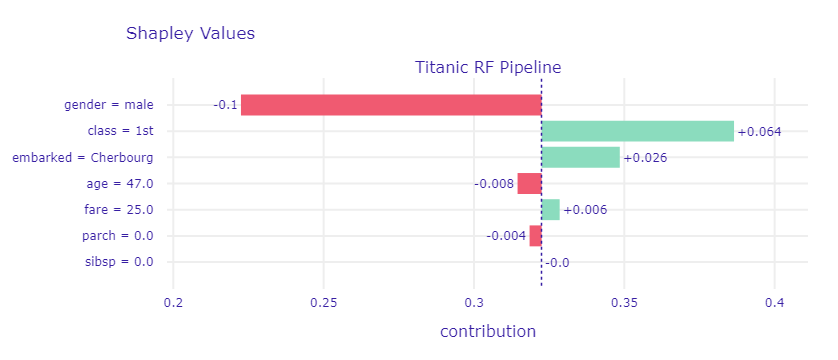

In [61]:
bd_henry.plot()

## 9 Local Interpretable Model-agnostic Explanations (LIME)

In [62]:
import dalex as dx
import lime

titanic = dx.datasets.load_titanic()
X = titanic.drop(columns='survived')
y = titanic.survived

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

X['gender']   = le.fit_transform(X['gender'])
X['class']    = le.fit_transform(X['class'])
X['embarked'] = le.fit_transform(X['embarked'])

In [63]:
from sklearn.ensemble import RandomForestClassifier as rfc
titanic_fr = rfc()
titanic_fr.fit(X, y)

RandomForestClassifier()

In [64]:
import pandas as pd
henry = pd.Series([1, 47.0, 0, 1, 25.0, 0, 0], 
                  index =['gender', 'age', 'class', 'embarked',
                          'fare', 'sibsp', 'parch']) 

In [65]:
X

,gender,age,class,embarked,fare,sibsp,parch
0,1,42.0,2,3,7.11,0,0
1,1,13.0,2,3,20.05,0,2
2,1,16.0,2,3,20.05,1,1
3,0,39.0,2,3,20.05,1,1
4,0,16.0,2,3,7.13,0,0
...,...,...,...,...,...,...,...
2202,1,41.0,3,0,0.00,0,0
2203,1,40.0,6,3,0.00,0,0
2204,1,32.0,4,3,0.00,0,0
2205,1,20.0,5,3,0.00,0,0


In [66]:
print(type(henry))
henry

<class 'pandas.core.series.Series'>


gender       1.0
age         47.0
class        0.0
embarked     1.0
fare        25.0
sibsp        0.0
parch        0.0
dtype: float64

In [67]:
from lime.lime_tabular import LimeTabularExplainer 
explainer = LimeTabularExplainer(X, 
                      feature_names=X.columns, 
                      class_names=['died', 'survived'], 
                      discretize_continuous=False, 
                      verbose=True)

In [68]:
lime = explainer.explain_instance(henry, titanic_fr.predict_proba)
lime.show_in_notebook(show_table=True)

Intercept 0.3471400502639044
Prediction_local [0.3641432]
Right: 0.27


## 10 Ceteris-paribus Profiles

In [79]:
import pandas as pd
henry = pd.DataFrame({'gender'   : ['male'],
                       'age'     : [47],
                       'class'   : ['1st'],
                       'embarked': ['Cherbourg'],
                       'fare'    : [25],
                       'sibsp'   : [0],
                       'parch'   : [0]},
                      index = ['Henry'])
import dalex as dx
titanic_rf_exp = dx.Explainer(titanic_rf, X, y, 
                    label = "Titanic RF Pipeline")

Preparation of a new explainer is initiated

  -> data              : 2207 rows 7 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2207 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Titanic RF Pipeline
  -> predict function  : <function yhat_proba_default at 0x000001BAEA6FD040> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         :  'residual_function' returns an Error when executed:
Found unknown categories [0, 1] in column 0 during transform
  -> model_info        : package sklearn

A new explainer has been created!


C:\Users\DNN\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:576: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

C:\Users\DNN\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

C:\Users\DNN\AppData\Roaming\Python\Python38\site-packages\dalex\_explainer\object.py:138: UserWarning:


  -> predicted values  : 'predict_function' returns an Error when executed: 
Found unknown categories [0, 1] in column 0 during transform

C:\Users\DNN\AppData\Roaming\Python\Python38\site-packages\dalex\_explainer\object.py:138: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)

C:\Users\DNN\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:576: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform 

In [80]:
cp_henry = titanic_rf_exp.predict_profile(henry)
cp_henry.result

TypeError: '<' not supported between instances of 'str' and 'float'

In [74]:
cp_henry.plot(variables = ['age', 'fare'])

NameError: name 'cp_henry' is not defined

In [75]:
cp_henry.plot(variables = ['class', 'embarked'],
               variable_type = 'categorical')

NameError: name 'cp_henry' is not defined